In [1]:
%matplotlib inline

import math
import json
import glob

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from moviepy.editor import ImageSequenceClip

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

Looking at the feature space over the span of an entire video instead of just a single image,

In [3]:
# Load a pre-trained ViT model
size = "small"
device = "cuda" if torch.cuda.is_available() else "cpu"

backbones = {
    "small": "vits14_reg",
    "base": "vitb14_reg",
    "large": "vitl14_reg",
    "giant": "vitg14_reg",
}

# We will use this encoder in the rest of the notebook
encoder = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=f"dinov2_{backbones[size]}").to(device)

Using cache found in /home/rob/.cache/torch/hub/facebookresearch_dinov2_main


In [4]:
# Load an example video
def extract_frames(video_path) -> list[np.ndarray]:
    video = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = video.read()
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    video.release()
    return frames

def generate_clip(output_frames, filename="output", fps=20):
    clip = ImageSequenceClip(output_frames, fps=20)
    clip.write_videofile(f"{filename}.mp4")

def closest_multiple(val, multiple):
    return int(multiple * round(val / multiple))
    
# Preprocess all the input image(s)
def transform(img, patch_size):
    height, width, _ = img.shape

    # Conform to the patch size of the ViT
    div_height = closest_multiple(height, patch_size)
    div_width = closest_multiple(width, patch_size)
    img = cv2.resize(img, (div_width, div_height))

    # Normalize the input
    img = (img - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    img /= 255

    # Move the channel dim
    img = img.transpose(2, 0, 1)
    return img, (div_height, div_width)
    
file_path = "koala.mp4"
frames = extract_frames(file_path)

original_height, original_width, _ = frames[0].shape
print(original_height, original_width)

# Preprocess all the frames
processed_frames = [transform(frame, encoder.patch_size)[0] for frame in frames]
frame_dim = transform(frames[0], encoder.patch_size)[1]

720 1280


In [ ]:
def visualize_features(features, encoder, frame_dim, seperate_foreground):
    patch_h = int(frame_dim[0] / encoder.patch_size)
    patch_w = int(frame_dim[1] / encoder.patch_size)
    patch_features = features.reshape(patch_h * patch_w, -1)
    
    # Apply PCA and MinMaxScaler
    pca = PCA(n_components=3)
    scaler = MinMaxScaler(clip=True)
    pca.fit(patch_features)
    pca_features = pca.transform(patch_features)
    scaler.fit(pca_features)
    pca_features = scaler.transform(pca_features)

    # Separate background and foreground
    if seperate_foreground:
        pca_background = pca_features[:, 0] > threshold
        pca_foreground = ~pca_background
    
        # Refit PCA for foreground
        pca.fit(patch_features[pca_foreground])
        pca_features_rem = pca.transform(patch_features[pca_foreground])
        scaler.fit(pca_features_rem)
        pca_features_rem = scaler.transform(pca_features_rem)

        pca_features_rgb = np.zeros(patch_h * patch_w, 3)
        pca_features_rgb[pca_background] = 0
        pca_features_rgb[pca_foreground] = pca_features_rem
        pca_features = pca_features_rgb.reshape(patch_h, patch_w, 3)

    # Convert the PCA features to an image
    pca_features = pca_features.reshape(patch_h, patch_w, 3)
    return pca_features

def visualize_frames(
    frames,
    encoder,
    image_dim=(),
    frame_dim=(),
    seperate_foreground=True
):
    output_frames = []
    for frame in frames:
        x = torch.tensor(frame).to(device).unsqueeze(0).float()
        
        # Extract features using the ViT model
        features_dict = encoder.forward_features(x)
        features = features_dict["x_norm_patchtokens"].detach().cpu().numpy()
        
        feature_frame = visualize_features(
            features,
            encoder,
            frame_dim,
            seperate_foreground
        )

        # Reshape to the original frame size
        feature_frame = (feature_frame * 255).astype(np.uint8)
        # Important, cv2 switches location of width and height
        height, width = image_dim
        feature_frame = cv2.resize(feature_frame, (width, height), cv2.INTER_NEAREST)
        output_frames.append(feature_frame)
    return output_frames

output_frames = visualize_frames(
    processed_frames,
    encoder,
    (original_height, original_width),
    frame_dim,
    seperate_foreground=False
)

# Now convert the processed frames to video
# For this I used an extra package.
generate_clip(output_frames)

# Example of the first output frame
plt.imshow(output_frames[0])

Now again, visualizing the features but instead of using the low resolution representation we upsample in feature space.

In [8]:
def visualize_features(features, frame_dim):
    B, C, H, W = features.shape
    features = features.permute(0, 2, 3, 1).reshape(B * H * W, C).numpy()
    
    # Apply PCA and MinMaxScaler
    pca = PCA(n_components=3)
    scaler = MinMaxScaler(clip=True)
    pca_features = scaler.fit_transform(pca.fit_transform(features))
    
    # Convert the PCA features to an image
    pca_features = pca_features.reshape(B, H, W, 3)
    return pca_features

def visualize_frames(frames, upsampler, image_dim, frame_dim, batch_size=16):
    feature_frames = []
    output_frames = []
    num_frames = len(frames)

    accumulated_features = []
    for i in range(0, num_frames, batch_size):
        batch_frames = frames[i:i + batch_size]
        batch_tensor = torch.tensor(batch_frames).to(device).float()
        features = upsampler(batch_tensor).detach().cpu()
        accumulated_features.append(features)

        # For the notebook code
        del batch_tensor
        torch.cuda.empty_cache()

        # PCA on every 40 frames
        if i % 40 == 0 and i != 0:        
            # Concatenate all batches along the batch dimension
            merged_features = torch.cat(accumulated_features, dim=0)

            # Process merged features to get feature frames
            feature_frames.append(visualize_features(merged_features, frame_dim))
            accumulated_features = []
            
            del merged_features
            torch.cuda.empty_cache()
            

    # We add the last few frames to the PCA feature frames
    merged_features = torch.cat(accumulated_features, dim=0)
    feature_frames.append(visualize_features(merged_features, frame_dim))

    # Concat and reshape every frame to retrieve the video
    feature_frames = np.concatenate(feature_frames, axis=0)
    
    for feature_frame in feature_frames:
        # Reshape to the original frame size
        feature_frame = (feature_frame * 255).astype(np.uint8)
        # Important, cv2 switches location of width and height
        height, width = image_dim 
        feature_frame = cv2.resize(feature_frame, (width, height), cv2.INTER_NEAREST)
        output_frames.append(feature_frame)
    
    return output_frames

# FeatUp combines the DINOv2 encoder with upsampling in the feature space
upsampler = torch.hub.load("mhamilton723/FeatUp", 'dinov2', use_norm=False).to(device)
upsampler.eval()

output_frames = visualize_frames(
    processed_frames[:500],
    upsampler,
    (original_height, original_width),
    frame_dim,
    batch_size=2,
)
generate_clip(output_frames)

Using cache found in /home/rob/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /home/rob/.cache/torch/hub/facebookresearch_dinov2_main


Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4


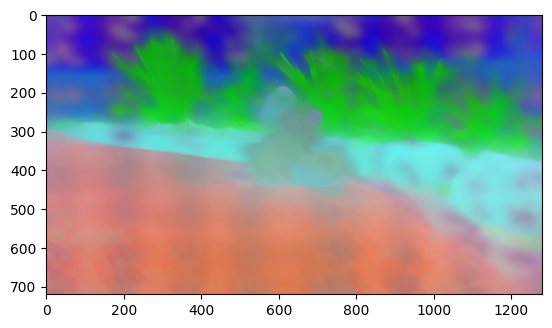

In [7]:
# Example of the first output frame
plt.imshow(output_frames[0])